# Intrusion Detection

### Project members:
- Tanzi Giuseppe (0001058210)
- Marini Daniele (0001060063)
- Zorila Iulian (0001033291)

##### To check results run the [Main Cell](#main_cell)

### Problem introduction
Starting from a given video:
- 12  frame/s  (total  duration is about 41 secs)
- 320x240  pixels
- 8 bit/pixel (256 gray levels)
- The sequence is compressed by the Radius Cinepak CODEC.

Whereby a person moves at different speed and is shown in various sizes. Moreover, in the last part the subject steals an object belonging to the scene, replacing it with another one.

<img src="Intruder.jpeg" width="320">
<center>Frame of replaced object.</center>

### Goal
Development of a software  system  that,  based  on  automatic  video  analysis,  can  detect objects (intruders) that do not belong to a static reference scene (background) and establish which of such objects are persons.

This is achieved by **background subtraction** and blob (Binary Large Object) labeling process, based upon **blob features** related to its size.

### Presentation structure
The following cells of code, can be roughly grouped into three principal parts:
- [Explanation](#Functions-explanation) of each function used within the main one. 
- [Intrusion detection pipeline](#Intrusion-detection-pipeline), consists of all the functions presented previously. 
- [Code execution](#main_cell) and writing results on file.

#### Import the needed libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys

# Import additional library to properply play videos on jupyter notebook
from IPython.display import clear_output

video_path = "data/video.avi"
print("Python version:", sys.version)
print("Opencv version:", cv2. __version__)

# Constants used in two different cells (consistency purposes)
OTHER = 'Other'
PERSON = 'Person'
AREA = 'Area'
PERIMETER = 'Perimeter'

Python version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Opencv version: 3.4.2


## Functions explanation
#### These functions implement the following distances between two frames:
* `l1` Manhattan distance: $L_1(i,j)=||F_t(i,j) - F_k(i,j)||_1 = \sum_{i=1}^n{|f_i^t(i,j) - f_i^k(i,j)|}$.
* `l2` Euclidean distance: $L_2(i,j)=||F_t(i,j) - F_k(i,j)||_2 = \sqrt{\sum_{i=1}^n{|f_i^t(i,j) - f_i^k(i,j)|^2}}$.
* `linf` Maximum distance: $L_{\infty}(i,j)=||F_t(i,j) - F_k(i,j)||_{\infty} = max_i(|f_i^t(i,j) - f_i^k(i,j)|), i=1..n$.

$F_t(i,j) = [f_1^t(i,j),…, f_n^t(i,j)]$ and $F_k(i,j) = [f_1^k(i,j),…, f_n^k(i,j)]$ are two frames with $n$ channels.

In [2]:
def l1(img1, img2):
    diff = np.abs(img1-img2)
    if img1.shape[-1] ==  3 and len(img1.shape)==3:
        # Sums the resulting difference along the RGB channel
        diff = np.sum(diff, axis=-1)
    return diff

def l2_distance(img1, img2):
    sq_dist = (img1-img2)**2
    if img1.shape[-1] ==  3 and len(img1.shape)==3:
        # Sums the squared distance along the RGB channel
        sq_dist = np.sum(sq_dist,axis=-1)
    diff = np.sqrt(sq_dist)
    return diff

def linf(img1, img2):
    diff = np.abs(img1 - img2)
    if img1.shape[-1] == 3 and len(img1.shape) == 3:
        # Takes the max value of the resulting difference along the RGB channel
        diff = np.max(diff, axis = -1)
    return diff

#### Support function to plot results and visually analyze them

In [3]:
import math

def plot_imgs(images, cols, figsize, titles=[]):
    '''
    Plots a list of images and works also for a single one.
    Choose the proper value for 'cols' according to the number of images to be plotted.
    '''
    imgs_count = len(images)
    rows = math.ceil(imgs_count/cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    
    # One row case, the axis are just an array (only presence of columns)
    if rows == 1:
        for y in range(cols):
            if len(images[-imgs_count].shape) < 3:
                # Gray level image
                axs[y].axis('off')
                axs[y].set_title(titles[-imgs_count])
                axs[y].imshow(images[-imgs_count], cmap='gray', vmin=0, vmax=255, aspect="auto")
            else:
                # Colored image
                axs[y].axis('off')
                axs[y].set_title(titles[-imgs_count])
                axs[y].imshow(images[-imgs_count], aspect="auto")
            imgs_count -= 1
            
    # Multiple rows and columns
    else:    
        for x in range(rows):
            for y in range(cols):
                if len(images[-imgs_count].shape) < 3:
                    # Gray level image
                    axs[x][y].axis('off')
                    axs[x][y].set_title(titles[-imgs_count])
                    axs[x][y].imshow(images[-imgs_count], cmap='gray', vmin=0, vmax=255, aspect="auto")
                else:
                    # Colored image
                    axs[x][y].axis('off')
                    axs[x][y].set_title(titles[-imgs_count])
                    axs[x][y].imshow(images[-imgs_count], aspect="auto")
                imgs_count -= 1
                
                # Columns may be more than the images to display
                if imgs_count == 0:
                    break
    plt.show()

#### Background extraction through interpolation of the `n_frames`.
The interpolation can be either the mean or the median

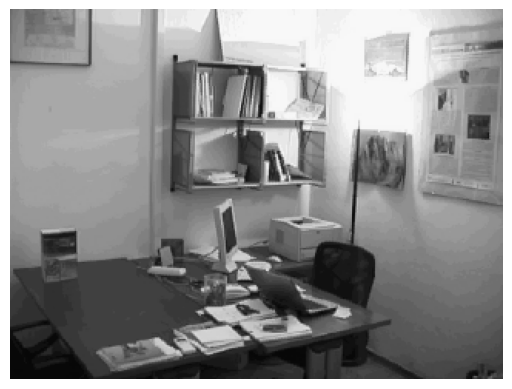

In [4]:
def extract_background(video_path, n_frames, interpolation):   
    '''
    Interpolates the first 'n_frames', through the function 'interpolation'.
    Returns the background image.
    '''
    cap = cv2.VideoCapture(video_path)
    i = 0
    frames = []
    frame0 = None
    
    # Store the first n_frames
    while(i < n_frames):
        if cap.isOpened():
            ret, frame = cap.read()
            if not ret or frame is None:
                # Release the Video if ret is false
                cap.release()
                break

            frames.append(frame.astype(float))
            
            i+= 1
        else:
            print('Video capture is not opened...')
            break

    # Compute the background throughout an interpolation
    stacked_frames = np.stack(frames, axis = 0)
    background = interpolation(stacked_frames, axis = 0)
    
    return background

n = 100
interpolation = np.median #np.mean

bg = extract_background(video_path, n, interpolation)
plt.imshow(bg.astype(np.uint8))
plt.axis('off')
plt.show()

#### These classes are employed to store the necessary data in an organized manner.

In [5]:
class Blob:
    def __init__(self, identifier, label, features):
        self.identifier = identifier
        self.label = label
        self.features = features

class Feature:
    def __init__(self, name, value):
        self.name = name
        self.value = value

#### `filter_mask` improves the mask quality. 
We use binary morphology operators, such as erosion and dilation in order to:
- remove small blobs.
- enhance the relevant ones.
- get rid of noise and image smoothing.

Moreover, we tried to apply directly opening and closing through `cv.morphologyEx(img, cv.MORPH_OPEN, kernel)`, obtaining results visually worse than the current one. Causing presence of multiple holes and as consequence the intruder turned out to be divided in more parts.

In [6]:
def filter_mask(frame, difference_img, th):
    '''
    Pipeline to process the mask obtained by subtracting the background to the frame.
    Allows to remove small blobs and unify internal parts of relevant ones.
    Returns:
        - The computed mask by thresholding
        - Result of last opening 
        - Result of closing
        - Image with the detected blobs
    '''
    mask = difference_img > th
    mask = np.array(mask, dtype = np.uint8)*255
    mask[mask!=0] = 255

    # Area opening
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (2,4))
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2,4))
    erode = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel_erode)
    dilation = cv2.morphologyEx(erode, cv2.MORPH_DILATE, kernel_dilate)
    area_opening = dilation
    
    # Closing
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (2,4))
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (12,24))
    dilation = cv2.morphologyEx(area_opening, cv2.MORPH_DILATE, kernel_dilate)
    erode = cv2.morphologyEx(dilation, cv2.MORPH_ERODE, kernel_erode)
    closing = erode
    
    # Opening
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (5,10))
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2,6))
    erode = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel_erode)
    dilation = cv2.morphologyEx(erode, cv2.MORPH_DILATE, kernel_dilate)
    opening = dilation
    
    return mask, opening, opening

#### `find_draw_contours` finds and draws the contours by taking advantage of the `cv2.findContours` function
More specifically, the parameters: 
- `cv2.RETR_EXTERNAL` allows to retrieve just the external contours without taking into account internal ones, which belong to their parents (e.g. unwanted holes)
- `cv2.CHAIN_APPROX_SIMPLE` avoids storing redundant points belonging to the contour (e.g. to represent a straight contour line, not all the points are needed)

In [7]:
def find_draw_contours(img_contours, img, colors, thickness):
    '''
    Finds the contours, then draws them with the input colors on the provided image 'img_contours'.
    '''
    
    _, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for i in range(len(contours)):
        cv2.drawContours(img_contours, [contours[i]], -1, colors[i], thickness)
    
    return img_contours, contours

#### `get_blobs_features` retrieves the area and perimeter of the blob through contours

In [8]:
def get_blobs_features(contours):
    '''
    Creates a list of Blob objects with their respective features, given the 'contours'.
    'contours' shall contain the contour of each detected object.
    '''
    blobs_features = []
    for i in range(len(contours)):
        a = Feature(AREA, cv2.contourArea(contours[i]))
        p = Feature(PERIMETER, cv2.arcLength(contours[i],True))
        blobs_features.append(Blob(i, None, {AREA: a, PERIMETER: p}))

    return blobs_features

## Intrusion detection pipeline
#### `show_intruder` detects changes in the video by performing the following steps:
1. Loads a frame
2. Computes difference between the background and the frame
3. Applies operations of Dilation and Erosion to improve the quality of the mask
4. Finds contours and draws them on the output image
5. Computes the Blob features
6. Plots the results

In [9]:
def show_intruder(video_path, start_frame, distance, th, colors, show_frames = True):
    '''
    Detects changes in the video, loaded from 'video_path':
        1. Loads a frame
        2. Computes difference between the background 'bg' and the 'frame'
        3. Applies operations of Dilation and Erosion to improve the quality of the mask
        4. Finds contours and draws them on the 'res' image
        5. Computes the Blob features
        6. Plots the results
    Returns a list where each element is a a list of Blob objects, with their respective features.
    The size of the list corresponds with the number of frames.
    '''
    cap = cv2.VideoCapture(video_path)
    cnt = 0
    all_blobs = []
    
    try:
        while(cap.isOpened()):
            
            # Load frame
            ret, frame = cap.read()
            
            if not ret or frame is None:
                cap.release()
                print("Released Video Resource")
                break
            
            if cnt > start_frame:
                
                # Compute difference between frame and background
                diff = distance(frame, bg)
                
                # Improve mask quality
                mask, opening, closing = filter_mask(frame, diff, th)

                # Find and draw contours for each detected blob
                res, contours = find_draw_contours(frame, opening, colors, thickness=2)

                # Append list of blobs detected within the frame, with their respective features
                all_blobs.append(get_blobs_features(contours))
                
                # Show frames if needed
                if show_frames:
                    plot_imgs([res, mask, opening], cols=3, figsize=(18,5), titles=["Countours","Mask","Mask after morphology operators"])

                clear_output(wait=True)
                
            cnt += 1
    except KeyboardInterrupt:
        cap.release()
        print("Released Video Resource")
    
    return all_blobs

### Main cell <a id='main_cell'></a>
1. Create a list of random colors, needed to drawn the blob contours.
2. Set the threshold and the distance function, needed as parameters for the `show_intruder` function.
3. Call the main function `show_intruder`.

In [10]:
seed = 42
np.random.seed(seed)

# Needed to draw contours
colors = [tuple(np.random.choice(range(256), size=3)) for x in range(200)]
for i in range(len(colors)):
    rgb = colors[i]
    colors[i] = (int(rgb[0]), int(rgb[1]), int(rgb[2]))

# Frames of interest
initial_frame = 0
steal_box_frame = 270
replace_box_frame = 305

threshold = 40
distance = linf
show_frames = True

all_blobs = show_intruder(video_path, 0, distance, threshold, colors, show_frames)

Released Video Resource


#### `store results` writes the outcomes on file and labels each detected blob depending on a threshold

In [11]:
def store_results(all_blobs, file_name='data/results.txt'):
    '''
    Writes on file a list, which contains the name and the features of all Blob objects.
    'all_blobs' is a list where each element is a list of Blob objects, detected in one frame.
    '''
    threshold = 6000
    
    file = open(file_name, "w")
    # Loop through blob list
    for frame_index in range(len(all_blobs)):
        n_detected_objs = len(all_blobs[frame_index])
        file.write(f'{frame_index}\t{n_detected_objs}\n')
        
        for b in all_blobs[frame_index]:
            # Write blob identifier
            file.write(f'{b.identifier}\t')
            
            # Write features and classify blobs according to a threshold
            for key, feature in b.features.items():
                file.write(f'{round(feature.value)}\t\t')
            if (b.features[AREA].value >= threshold):
                b.label = PERSON
            else:
                b.label = OTHER
            file.write(f'{b.label}\n')
        file.write('\n')
    file.close()

store_results(all_blobs)